# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
---



## Introduction: Business Problem 
In this project we will explore the toronto area and find the best locations to open a restaurant
The focus is to maximize business for a Indian Restaurant in Toronto Canada

In [1]:
pip install bs4

## Importing all the required libraries

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import os
import json
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

## Retriving postcodes of Toronto,Canada from 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page, "html.parser")

In [4]:
debug = False
table = soup.find('table')

Postcode      = []
Borough       = []
Neighborhood = []


counter = 0
Postcode_var      = None
Borough_var       = None
Neighbourhood_var = None
# extracting a clean form of the table
for tr_cell in table.find_all('tr'):
    if counter == 0:
        counter = 1
        continue
        
    info = tr_cell.find_all('td')
    Postcode_var = info[0].text.strip()
    Borough_var = info[1].text.strip()
    Neighborhood_var = info[2].text.replace('/', ',').strip()
    

    if Borough_var == 'Not assigned':
        counter += 1
        continue
    
    if Neighbourhood_var == 'Not assigned':
        Neighborhood_var = Borough_var
    
    
    Postcode.append(Postcode_var)
    Borough.append(Borough_var)
    Neighborhood.append(Neighborhood_var)
    
    if debug: 
        print('counter :', counter)
        print('Postcode_var :',Postcode_var)
        print('Borough_var :', Borough_var)
        print('Neighborhood_var :',Neighborhood_var) 
        print('x'*40)
            
    counter += 1

In [5]:
toronto_dict = {'Postal Code':Postcode, 'Borough':Borough, 'Neighborhood':Neighborhood}
df_toronto = pd.DataFrame.from_dict(toronto_dict)

In [6]:
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


## Loading the geospatial data from a csv file

In [7]:
#loading the geospatial_data
geospatial_data = pd.read_csv("Geospatial_Coordinates.csv")
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
neighborhoods = df_toronto.merge(geospatial_data, on='Postal Code')
neighborhoods.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


In [9]:
# Merging the two dataframe and droping the Postal Code column
neighborhoods = neighborhoods.drop(columns='Postal Code')

In [10]:
list(neighborhoods.Borough.unique())

['North York',
 'Downtown Toronto',
 'Etobicoke',
 'Scarborough',
 'East York',
 'York',
 'East Toronto',
 'West Toronto',
 'Central Toronto',
 'Mississauga']

## Using Nominatim from Geopy we can retrive the longitude and latitude information about Toronto

In [11]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


## Visualizing the available Neighborhoods in Toronto

In [12]:
import folium

In [13]:
list(neighborhoods.columns)

['Borough', 'Neighborhood', 'Latitude', 'Longitude']

In [14]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude],tiles='Stamen Toner', zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    folium.Marker(
        [lat, lng],
        popup=label,
        color='blue',
        fill_opacity=0.7
        ).add_to(map_toronto)  

map_toronto

In [15]:
CLIENT_ID = 'JKKLZNOSIQT4F3SOVNQY3O4UTGJZ3TVPBQKQB0KCT1KB5UTQ' # your Foursquare ID
CLIENT_SECRET = 'GDEGJUMGDBLS32KDF2QAIX4FCCHUGKQF3JFFXMM3XH5MMDN1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JKKLZNOSIQT4F3SOVNQY3O4UTGJZ3TVPBQKQB0KCT1KB5UTQ
CLIENT_SECRET:GDEGJUMGDBLS32KDF2QAIX4FCCHUGKQF3JFFXMM3XH5MMDN1


## Using Foursquare Venue GET request, We retrive all the famous venues in the all the neighborhoods

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Queen's Park , Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills
Parkview Hill , Woodbine Gardens
Garden District , Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
East Toronto
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village
D

In [18]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [19]:
venues.shape

(1349, 7)

### One hot encoding the Categories of the Venues and apending the Neighborhood column to that dataframe

In [20]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]


In [21]:
venues_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
print('Total number of categories : {}'.format(venues_onehot.shape[1] - 1))

Total number of categories : 233


In [23]:
list_of_category = list(venues_onehot.columns)

In [24]:
list_of_restaurant_category = []
for each in list_of_category:
    check = "Restaurant"
    if check in each:
        list_of_restaurant_category.append(each)

list_of_restaurant_category.append('Neighborhood')

### Filtering the venue categories list to only restuarants

In [25]:
venues_onehot_restaurant = venues_onehot[list_of_restaurant_category]

In [26]:
venues_onehot_restaurant

,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Victoria Village
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Mimico NW , The Queensway West , South of Bloo..."
1345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Mimico NW , The Queensway West , South of Bloo..."
1346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Mimico NW , The Queensway West , South of Bloo..."
1347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Mimico NW , The Queensway West , South of Bloo..."


## There are 38 different kind of restuarants in the neighborhoods of toronto, and many unlabled restaurants which we will treat as Multi-cusine restaurants

In [27]:
print('Total number of restaurant type : {}'.format(venues_onehot_restaurant.shape[1] - 1))

Total number of restaurant type : 39


### To Find out the most famous restuarants neighborhood wise we group the above information by Neighborhoods and check for the 5 highest frequencies of visits

In [28]:
grouped = venues_onehot_restaurant.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,"Alderwood , Long Branch",0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,"Bathurst Manor , Wilson Heights , Downsview North",0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.052632,0.0,0.052632,0.0,0.000000,0.0,0.0,0.000000
3,Bayview Village,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,"Bedford Park , Lawrence Manor East",0.041667,0.0,0.0,0.0,0.0,0.00,0.0,0.041667,0.0,...,0.0,0.000000,0.083333,0.0,0.083333,0.0,0.041667,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,"Wexford , Maryvale",0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
89,Willowdale,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.083333,0.027778,0.0,0.027778,0.0,0.000000,0.0,0.0,0.027778
90,Woburn,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
91,Woodbine Heights,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [29]:
num_top_venues = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1        American Restaurant   0.0
2      Portuguese Restaurant   0.0
3          Korean Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Alderwood , Long Branch----
                       venue  freq
0        American Restaurant   0.0
1      Portuguese Restaurant   0.0
2          Korean Restaurant   0.0
3  Latin American Restaurant   0.0
4   Mediterranean Restaurant   0.0


----Bathurst Manor , Wilson Heights , Downsview North----
                       venue  freq
0           Sushi Restaurant  0.05
1  Middle Eastern Restaurant  0.05
2                 Restaurant  0.05
3        American Restaurant  0.00
4    New American Restaurant  0.00


----Bayview Village----
                       venue  freq
0        Japanese Restaurant  0.25
1         Chinese Restaurant  0.25
2      Portuguese Restaurant  0.00
3          Korean Restaurant  0.00
4  Latin American Restaurant  0.00


----Bedford Park , L

                           venue  freq
0             Italian Restaurant  0.07
1               Sushi Restaurant  0.07
2             Falafel Restaurant  0.03
3  Vegetarian / Vegan Restaurant  0.03
4      Latin American Restaurant  0.03


----Runnymede , The Junction North----
                       venue  freq
0       Caribbean Restaurant  0.33
1        American Restaurant  0.00
2      Portuguese Restaurant  0.00
3          Korean Restaurant  0.00
4  Latin American Restaurant  0.00


----Scarborough Village----
                       venue  freq
0        American Restaurant   0.0
1      Portuguese Restaurant   0.0
2          Korean Restaurant   0.0
3  Latin American Restaurant   0.0
4   Mediterranean Restaurant   0.0


----South Steeles , Silverstone , Humbergate , Jamestown , Mount Olive , Beaumond Heights , Thistletown , Albion Gardens----
                       venue  freq
0       Fast Food Restaurant  0.11
1        American Restaurant  0.00
2         Italian Restaurant  0.00
3       

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('Rank {}'.format(ind+1))
    except:
        columns.append('Rank {}'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1,"Alderwood , Long Branch",Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,"Bedford Park , Lawrence Manor East",Restaurant,Italian Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Greek Restaurant,Comfort Food Restaurant,Thai Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant


## Recording neighborhood wise popularity information in a dataframe

In [32]:
# set number of clusters
kclusters = 8
grouped = venues_onehot_restaurant.groupby('Neighborhood').mean().reset_index()
grouped_clustering = grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 6, 0, 0, 4, 0, 1, 4])

## Lets see how similar these neighborhoods in terms of preference in restaurant types

In [33]:
neighborhoods_venues_sorted.head()

,Neighborhood,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
0,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1,"Alderwood , Long Branch",Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
2,"Bathurst Manor , Wilson Heights , Downsview North",Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,"Bedford Park , Lawrence Manor East",Restaurant,Italian Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Greek Restaurant,Comfort Food Restaurant,Thai Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant


In [37]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
neighborhoods_venues_sorted.columns

Index(['Neighborhood', 'Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5',
       'Rank 6', 'Rank 7', 'Rank 8', 'Rank 9', 'Rank 10'],
      dtype='object')

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
0,North York,Parkwoods,43.753259,-79.329656,4.0,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
1,North York,Victoria Village,43.725882,-79.315572,4.0,French Restaurant,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,4.0,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,4.0,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
4,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,4.0,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [39]:
merged.dropna(inplace=True)
merged['Cluster Labels'].astype('int')

0      4
1      4
2      4
3      4
4      4
      ..
98     4
99     0
100    1
101    4
102    1
Name: Cluster Labels, Length: 98, dtype: int32

In [40]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Lets see what these clusters have in common

Number of Neighborhoods in each cluster


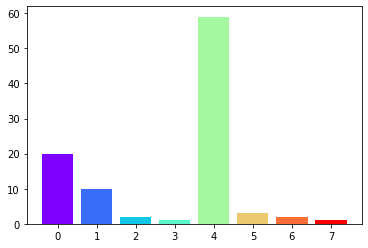

In [71]:
col = ['Cluster Labels' , 'Rank 1', 'Rank 2', 'Rank 3']
df_similarity = merged[col]
print('Number of Neighborhoods in each cluster')
df_plot=df_similarity['Cluster Labels'].value_counts().to_frame().sort_index().reset_index()
df_plot.columns = ['L', 'C']
plt.bar(df_plot.L, df_plot.C, color=rainbow)
plt.xlabel='Cluster'
plt.ylabel= 'Count'
plt.show()


## It looks like cluster 0, 4, and 1 are the most popular lets explore

### Exploring most popular cluster, cluster 4

In [111]:
print('Rank 1 : \n', df_similarity[df_similarity['Cluster Labels'] == 4]['Rank 1'].value_counts())
print('\nRank 2 : \n',df_similarity[df_similarity['Cluster Labels'] == 4]['Rank 2'].value_counts())
print('\nRank 3 : \n',df_similarity[df_similarity['Cluster Labels'] == 4]['Rank 3'].value_counts())

Rank 1 : 
 Vietnamese Restaurant        36
Middle Eastern Restaurant     3
American Restaurant           3
Sushi Restaurant              3
French Restaurant             2
Mexican Restaurant            2
Italian Restaurant            2
Ramen Restaurant              2
Korean Restaurant             1
Latin American Restaurant     1
Greek Restaurant              1
Chinese Restaurant            1
New American Restaurant       1
Mediterranean Restaurant      1
Name: Rank 1, dtype: int64

Rank 2 : 
 Dim Sum Restaurant            34
Vietnamese Restaurant         10
Italian Restaurant             3
Sushi Restaurant               2
Thai Restaurant                2
Restaurant                     2
Middle Eastern Restaurant      1
Mexican Restaurant             1
Portuguese Restaurant          1
Mediterranean Restaurant       1
Modern European Restaurant     1
Asian Restaurant               1
Name: Rank 2, dtype: int64

Rank 3 : 
 Greek Restaurant                 34
Indian Restaurant              

## It looks like Veitnamese, Dim sum and Greek food is very popular in these neighborhoods

### Exploring second most popular cluster, cluster 0

In [112]:
print('Rank 1 : \n', df_similarity[df_similarity['Cluster Labels'] == 0]['Rank 1'].value_counts())
print('\nRank 2 : \n',df_similarity[df_similarity['Cluster Labels'] == 0]['Rank 2'].value_counts())
print('\nRank 3 : \n',df_similarity[df_similarity['Cluster Labels'] == 0]['Rank 3'].value_counts())

Rank 1 : 
 Italian Restaurant       4
Seafood Restaurant       3
Restaurant               3
American Restaurant      2
Japanese Restaurant      2
Asian Restaurant         2
Sushi Restaurant         1
Cuban Restaurant         1
Vietnamese Restaurant    1
Theme Restaurant         1
Name: Rank 1, dtype: int64

Rank 2 : 
 Restaurant                       7
American Restaurant              3
Italian Restaurant               3
Thai Restaurant                  2
Japanese Restaurant              1
Sushi Restaurant                 1
Seafood Restaurant               1
Vegetarian / Vegan Restaurant    1
Fast Food Restaurant             1
Name: Rank 2, dtype: int64

Rank 3 : 
 Restaurant                       4
Japanese Restaurant              3
American Restaurant              2
Sushi Restaurant                 2
Vietnamese Restaurant            2
Comfort Food Restaurant          1
Vegetarian / Vegan Restaurant    1
Greek Restaurant                 1
Thai Restaurant                  1
Asian Resta

## In these neighborhoods Italian, American and unlabelled restuarants seem to be famous

---

## Now lets explore how many of each type of restaurant exist in toronto

In [113]:
df_count=venues_onehot_restaurant.drop(['Neighborhood'], axis=1)
df_count = df_count.sum(axis = 0, skipna = True).to_frame()
df_count = df_count.reset_index()
df_count.columns = ['Restaurant Type', 'Count']
df_count.Count.astype('int64')
df_count = df_count.sort_values('Count', ascending=False)
df_count.head()

,Restaurant Type,Count
31,Restaurant,38
20,Italian Restaurant,28
21,Japanese Restaurant,20
33,Sushi Restaurant,19
13,Fast Food Restaurant,18


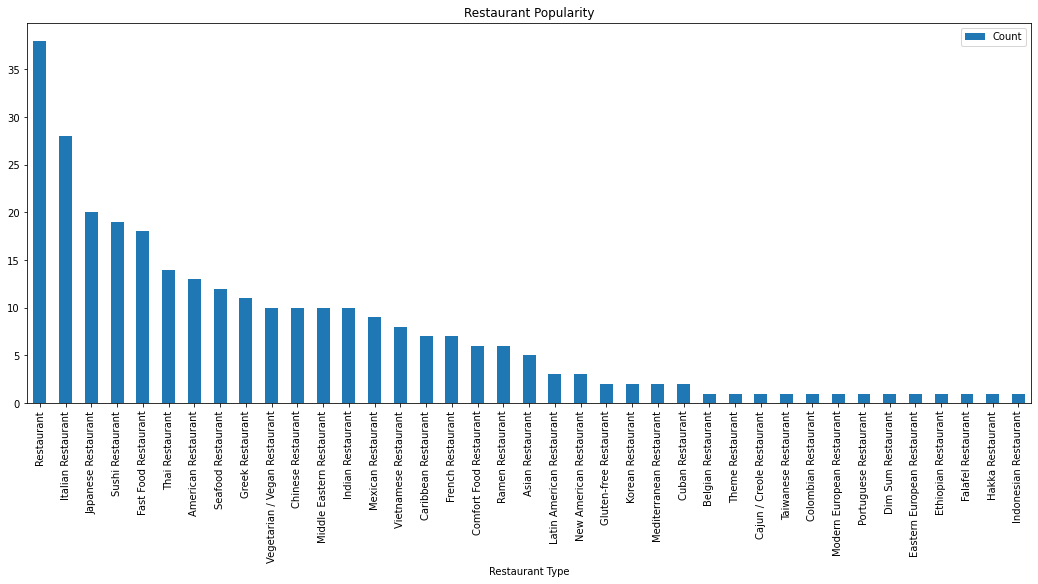

In [114]:
df_count.plot(kind = 'bar', x ='Restaurant Type', y = 'Count', figsize = (18,7), title = 'Restaurant Popularity')

In [115]:
df_count[df_count['Restaurant Type']=='Indian Restaurant']


,Restaurant Type,Count
18,Indian Restaurant,10


### A lot of Unlabeled restaurants, Japanese, Italian, Sushi and fast food chains seem to exist with only 10 popular Indian Restaurants

### Lets explore where these Restaurants are famous in: 

In [116]:
df=neighborhoods_venues_sorted

In [117]:
df_rank1 = df[df['Rank 1']=='Indian Restaurant']
df_rank1[['Neighborhood', 'Cluster Labels']]

,Neighborhood,Cluster Labels
23,"Dorset Park , Wexford Heights , Scarborough To...",7
82,Thorncliffe Park,1


In [118]:
df_rank2 = df[df['Rank 2']=='Indian Restaurant']
df_rank2[['Neighborhood', 'Cluster Labels']]

,Neighborhood,Cluster Labels


In [119]:
df_rank3 = df[df['Rank 3']=='Indian Restaurant']
df_rank3[['Neighborhood', 'Cluster Labels']]

,Neighborhood,Cluster Labels
0,Agincourt,4
25,"Dufferin , Dovercourt Village",4
32,Glencairn,6
34,"Guildwood , Morningside , West Hill",4
37,Hillcrest Village,4
73,"St. James Town , Cabbagetown",0
74,"Steeles West , L'Amoreaux West",1
88,"Wexford , Maryvale",4
90,Woburn,4


In [120]:
df_rank4 = df[df['Rank 4']=='Indian Restaurant']
df_rank4[['Neighborhood', 'Cluster Labels']]

,Neighborhood,Cluster Labels
78,"The Annex , North Midtown , Yorkville",4


In [121]:
df_rank5 = df[df['Rank 5']=='Indian Restaurant']
df_rank5[['Neighborhood', 'Cluster Labels']]

,Neighborhood,Cluster Labels
4,"Bedford Park , Lawrence Manor East",0
19,Davisville,0


## Most of these restaurants are famous in clusters 7, 4 and 6

In [131]:
Indian_popular_cluster = [7, 4, 6]
merged_indpop = merged[merged['Cluster Labels'].isin(Indian_popular_cluster)]

In [132]:
merged_indpop.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
0,North York,Parkwoods,43.753259,-79.329656,4.0,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
1,North York,Victoria Village,43.725882,-79.315572,4.0,French Restaurant,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,4.0,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,4.0,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Cuban Restaurant
4,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,4.0,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [133]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_indpop['Latitude'], merged_indpop['Longitude'], merged_indpop['Neighborhood'], merged_indpop['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [87]:
LocInd = grouped[grouped['Indian Restaurant'] > 0]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('Rank {}'.format(ind+1))
    except:
        columns.append('Rank {}'.format(ind+1))

# create a new dataframe
Ind_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
Ind_neighborhoods_venues_sorted['Neighborhood'] = LocInd['Neighborhood']

for ind in np.arange(LocInd.shape[0]):
    Ind_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LocInd.iloc[ind, :], num_top_venues)

    
indmerged = neighborhoods


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
indmerged = indmerged.merge(Ind_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

indmerged.head()

,Borough,Neighborhood,Latitude,Longitude,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Rank 6,Rank 7,Rank 8,Rank 9,Rank 10
0,East York,Thorncliffe Park,43.705369,-79.349372,Indian Restaurant,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Falafel Restaurant,Ethiopian Restaurant
1,North York,"Bedford Park , Lawrence Manor East",43.733283,-79.419750,Restaurant,Italian Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Greek Restaurant,Comfort Food Restaurant,Thai Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant
2,Scarborough,"Dorset Park , Wexford Heights , Scarborough To...",43.757410,-79.273304,Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Eastern European Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,Central Toronto,"The Annex , North Midtown , Yorkville",43.672710,-79.405678,American Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Cajun / Creole Restaurant,Ethiopian Restaurant,Asian Restaurant,Greek Restaurant,Gluten-free Restaurant,French Restaurant
4,Central Toronto,Davisville,43.704324,-79.388790,Sushi Restaurant,Italian Restaurant,Greek Restaurant,Thai Restaurant,Indian Restaurant,Seafood Restaurant,Restaurant,Dim Sum Restaurant,French Restaurant,Fast Food Restaurant


In [88]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude],tiles='Stamen Toner', zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(indmerged['Latitude'], indmerged['Longitude'], indmerged['Borough'], indmerged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    folium.Marker(
        [lat, lng],
        popup=label,
        color='blue',
        fill_opacity=0.7
        ).add_to(map_toronto)  

map_toronto

# Conclusion
It looks like Indian Restaurants are famous all around toronto but there is only 10 famous Indian restaurant chains. 
So the location would not matter much, If the owner is confident that he can make his restaurant well renowned business will flourish, however if you do not feel confident it Italian and Veitnameese restaurants do well in downtown Toronto. 